Load the data

In [1]:
import pandas as pd
df = pd.read_csv("/content/covtype.csv")  # or the file name from Kaggle/UCI
df.shape  # expect (581012, 55) if target included


(581012, 55)

Quick EDA & preprocessing

In [3]:
# --- EDA
print(df.shape)
print(df.columns[:15].tolist())   # first few column names
print(df['Cover_Type'].value_counts(normalize=True))  # class distribution

# --- Missing values?
print(df.isna().sum().any())  # should be False for this dataset

# --- Map target to 0..6 (optional, keeps tidy for XGBoost)
df['target'] = df['Cover_Type'].astype(int) - 1   # 0..6
df.drop(columns=['Cover_Type'], inplace=True)
X = df.drop(columns=['target'])
y = df['target']


(581012, 55)
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1']
Cover_Type
2    0.487599
1    0.364605
3    0.061537
7    0.035300
6    0.029891
5    0.016339
4    0.004728
Name: proportion, dtype: float64
False


Train/test split (stratified)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Baseline: Random Forest (fast baseline)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import time

rf = RandomForestClassifier(
    n_estimators=100,   # start small; increase for final runs
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

t0 = time.time()
rf.fit(X_train, y_train)
print("train time:", time.time()-t0)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


train time: 139.77675485610962


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.7s


              precision    recall  f1-score   support

           0       0.96      0.94      0.95     42368
           1       0.95      0.97      0.96     56661
           2       0.94      0.96      0.95      7151
           3       0.92      0.86      0.89       549
           4       0.95      0.77      0.85      1899
           5       0.93      0.89      0.91      3473
           6       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.5s finished


XGBoost

In [10]:
from xgboost import XGBClassifier
# from xgboost.callback import EarlyStopping # Removed import as callbacks are not used

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=7,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,  # for recent xgboost versions
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42
)

# Removing early stopping due to version incompatibility
xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:35:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.75746
[1]	validation_0-mlogloss:1.61010
[2]	validation_0-mlogloss:1.49119
[3]	validation_0-mlogloss:1.39085
[4]	validation_0-mlogloss:1.30601
[5]	validation_0-mlogloss:1.23272
[6]	validation_0-mlogloss:1.16796
[7]	validation_0-mlogloss:1.10996
[8]	validation_0-mlogloss:1.05842
[9]	validation_0-mlogloss:1.01270
[10]	validation_0-mlogloss:0.97109
[11]	validation_0-mlogloss:0.93452
[12]	validation_0-mlogloss:0.90096
[13]	validation_0-mlogloss:0.87085
[14]	validation_0-mlogloss:0.84296
[15]	validation_0-mlogloss:0.81788
[16]	validation_0-mlogloss:0.79491
[17]	validation_0-mlogloss:0.77411
[18]	validation_0-mlogloss:0.75496
[19]	validation_0-mlogloss:0.73745
[20]	validation_0-mlogloss:0.72140
[21]	validation_0-mlogloss:0.70627
[22]	validation_0-mlogloss:0.69230
[23]	validation_0-mlogloss:0.67934
[24]	validation_0-mlogloss:0.66758
[25]	validation_0-mlogloss:0.65641
[26]	validation_0-mlogloss:0.64635
[27]	validation_0-mlogloss:0.63686
[28]	validation_0-mlogloss:0.6

Hyperparameter tuning (RandomizedSearchCV example)

In [11]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10]
}

rs_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
    param_distributions=param_dist_rf,
    n_iter=12,  # keep small for demo; increase for thorough search
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

rs_rf.fit(X_train.sample(100000, random_state=42), y_train.loc[X_train.sample(100000, random_state=42).index])
# Note: the .sample shown above avoids tuning on the full 580k dataset.


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400]},
                   random_state=42, scoring='accuracy', verbose=2)

XGBoost hyperparam tuning (RandomizedSearchCV)

In [13]:
param_dist_xgb = {
    'n_estimators': [100, 200, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

rs_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(objective='multi:softprob', num_class=7, use_label_encoder=False, n_jobs=-1, random_state=42, eval_metric='mlogloss'),
    param_distributions=param_dist_xgb,
    n_iter=12,
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)
# Again, consider using a subset for quick iteration, then re-run the best params on full data.


Confusion matrix & feature importance (plots)

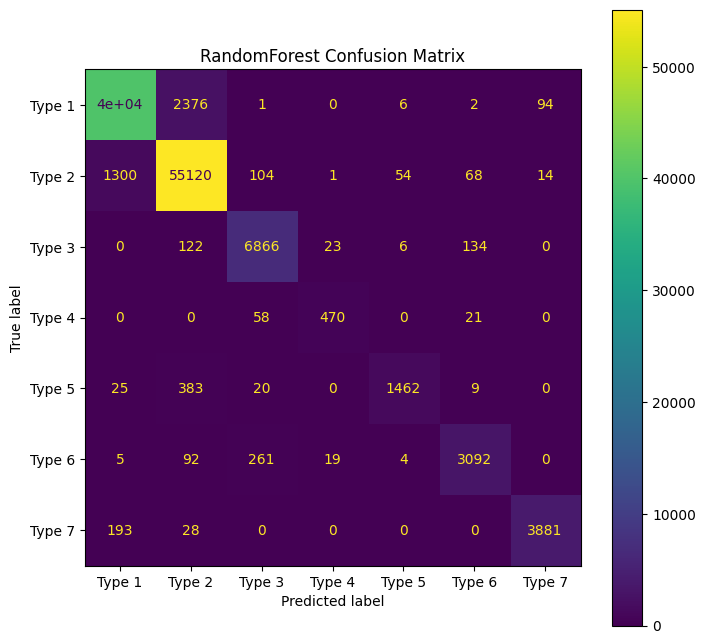

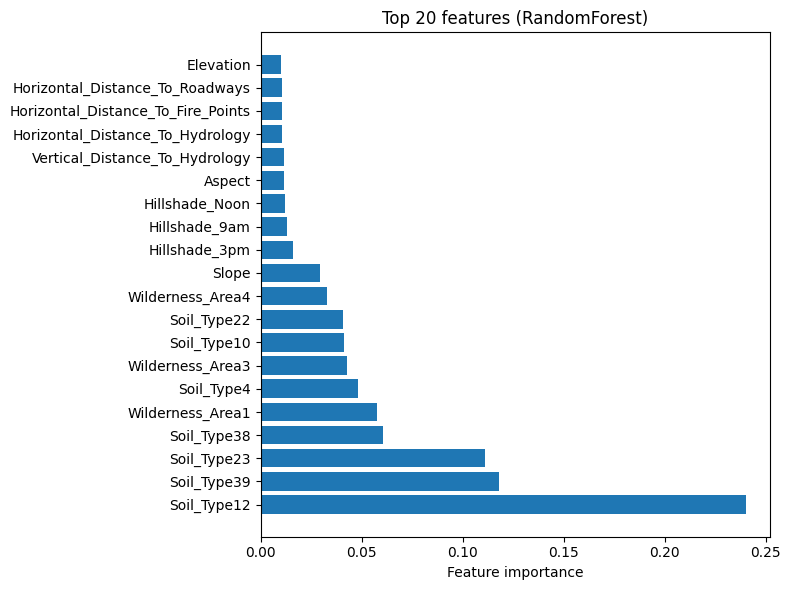

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Type {i+1}" for i in range(7)])
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.title("RandomForest Confusion Matrix")
plt.show()

# Feature importance (top 20)
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.barh(range(len(fi))[::-1], fi.values[::-1])
plt.yticks(range(len(fi)), fi.index[::-1])
plt.xlabel("Feature importance")
plt.title("Top 20 features (RandomForest)")
plt.tight_layout()
plt.show()


Class distribution (bar chart)

/tmp/ipython-input-3232818559.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


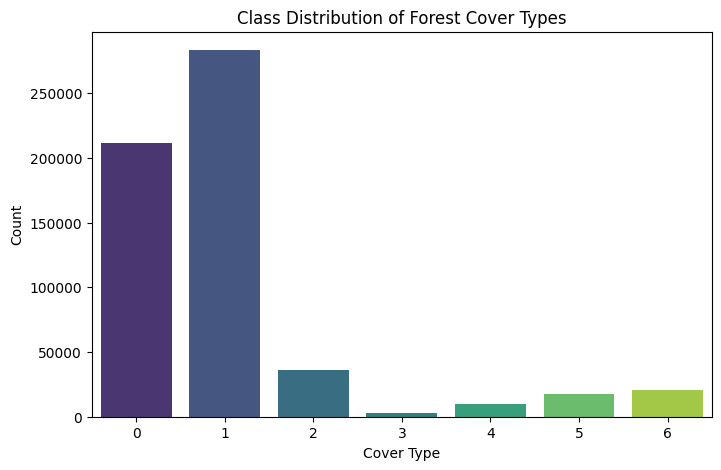

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(x=y, palette="viridis")
plt.xlabel("Cover Type")
plt.ylabel("Count")
plt.title("Class Distribution of Forest Cover Types")
plt.show()


Feature histograms (for numeric features)

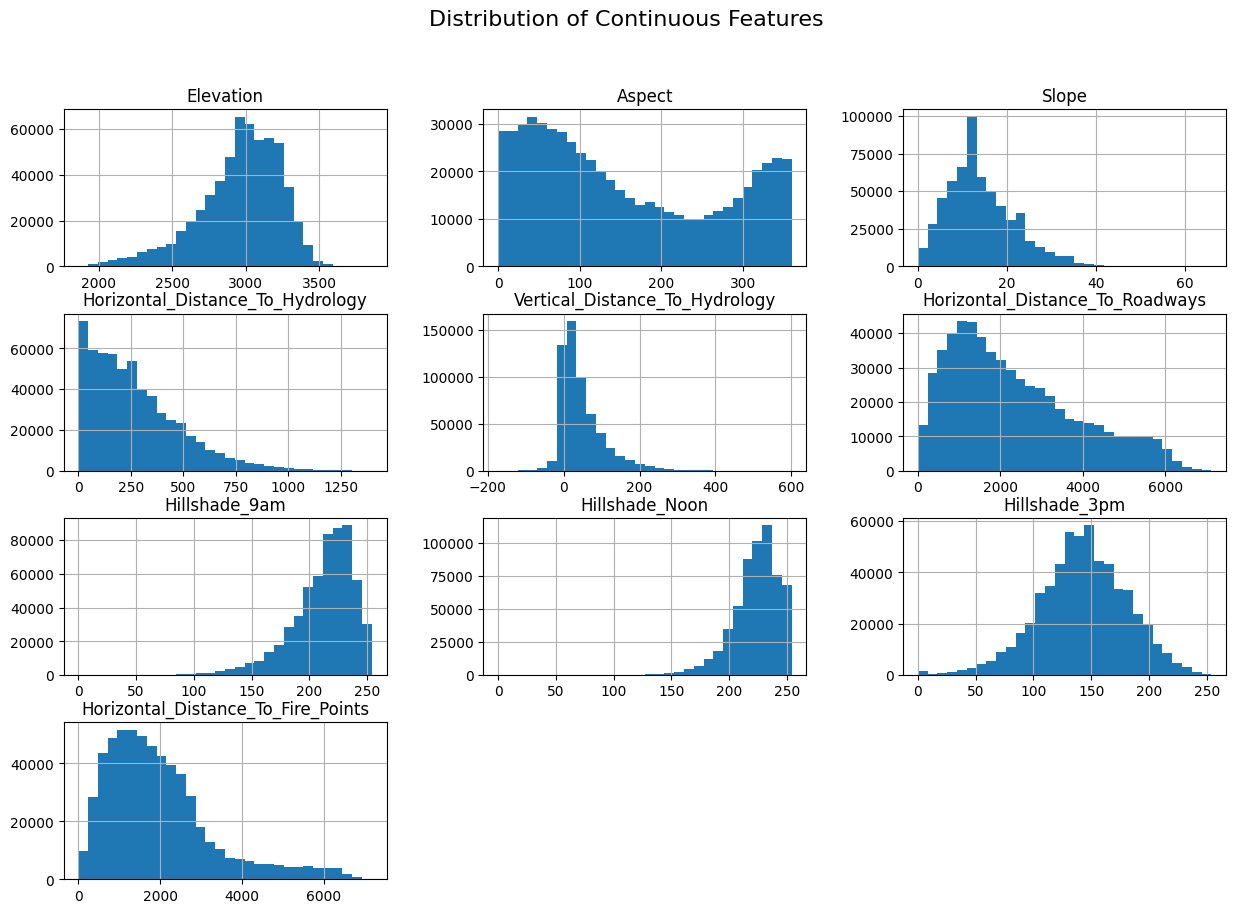

In [16]:
num_features = ["Elevation","Aspect","Slope","Horizontal_Distance_To_Hydrology",
                "Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Roadways",
                "Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"]

df[num_features].hist(bins=30, figsize=(15,10))
plt.suptitle("Distribution of Continuous Features", size=16)
plt.show()


Pairplot (sampled, for clarity)

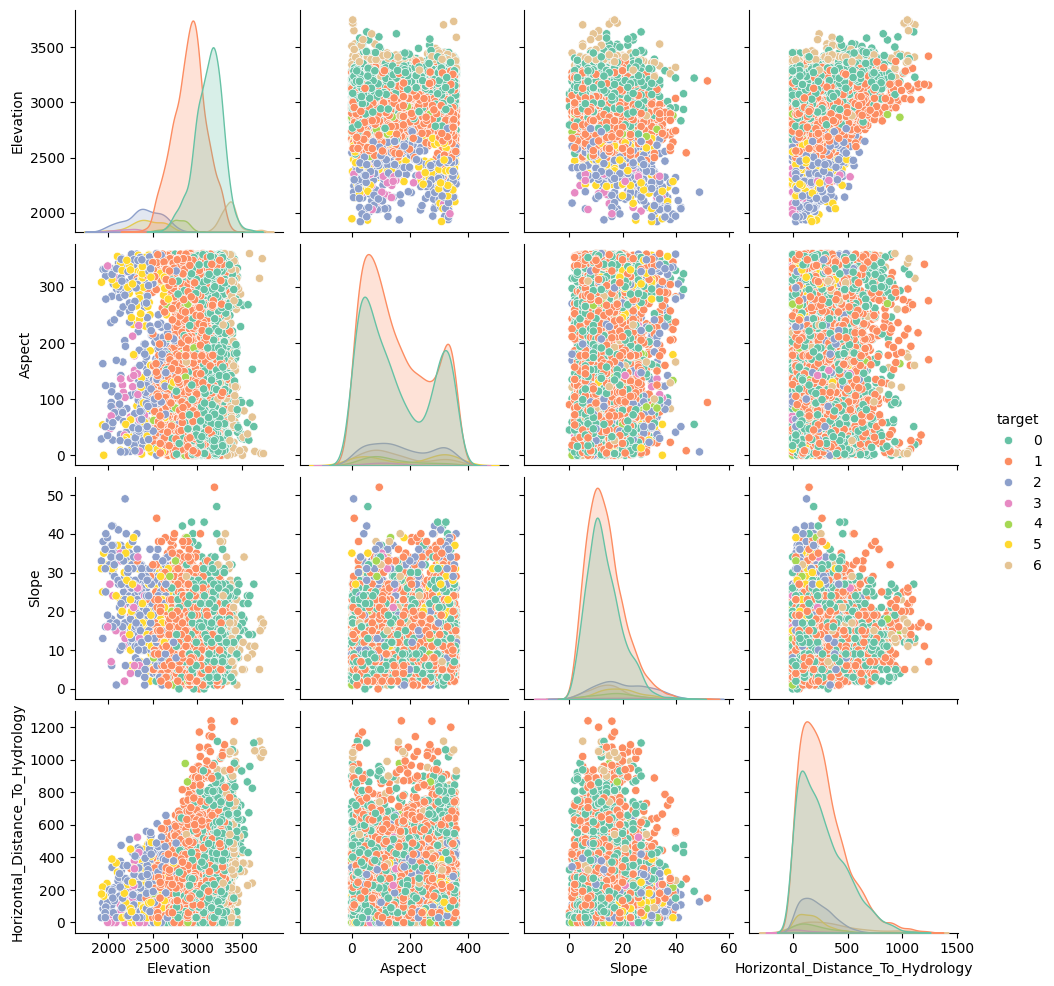

In [17]:
sample_df = df.sample(5000, random_state=42)  # sample for speed
sns.pairplot(sample_df[num_features[:4] + ["target"]], hue="target", palette="Set2")
plt.show()


Correlation heatmap (numeric features only)

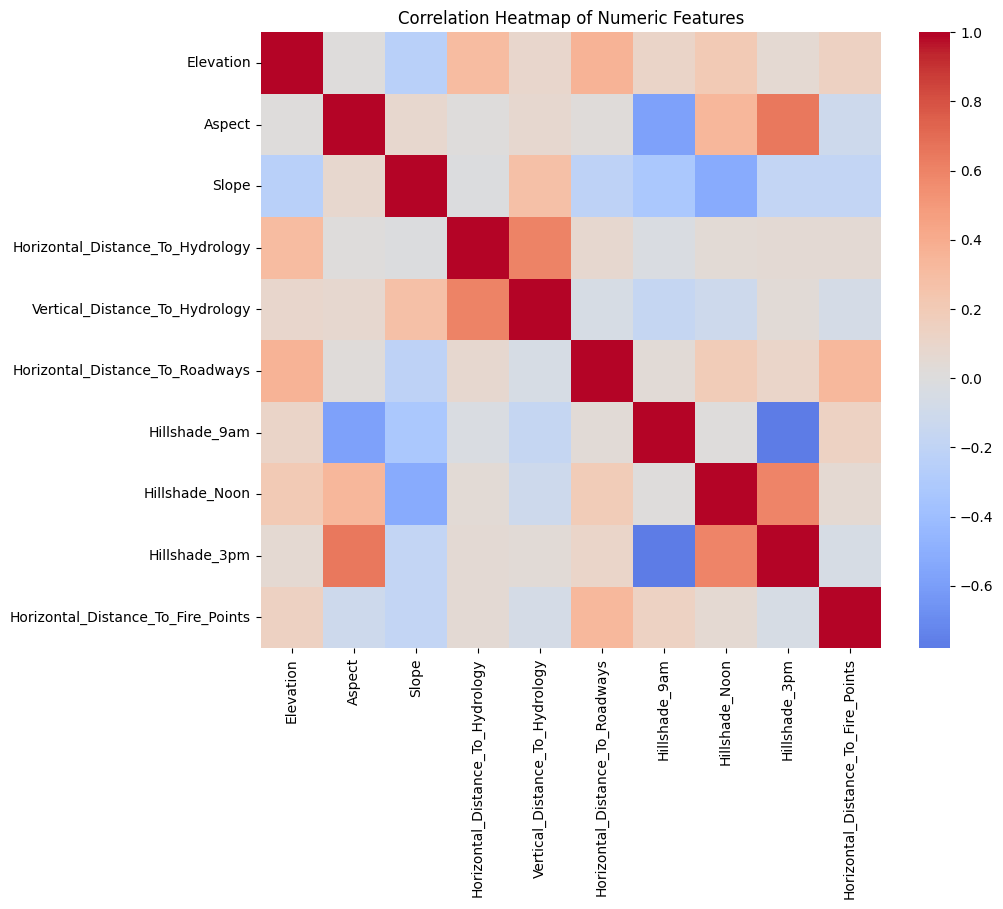

In [18]:
corr = df[num_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


Feature importance comparison (Random Forest vs. XGBoost)

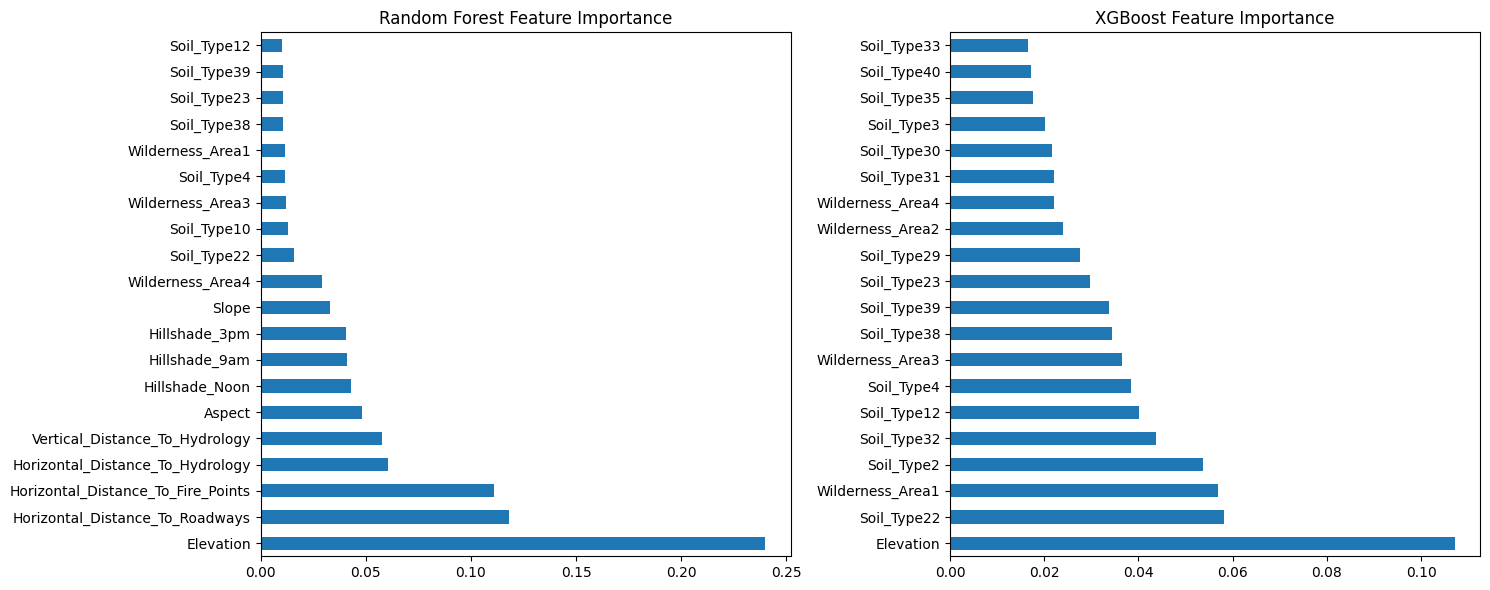

In [19]:
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:20]
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)[:20]

fig, axes = plt.subplots(1,2, figsize=(15,6))
rf_importances.plot(kind="barh", ax=axes[0], title="Random Forest Feature Importance")
xgb_importances.plot(kind="barh", ax=axes[1], title="XGBoost Feature Importance")
plt.tight_layout()
plt.show()


Confusion matrix (normalized for better readability)

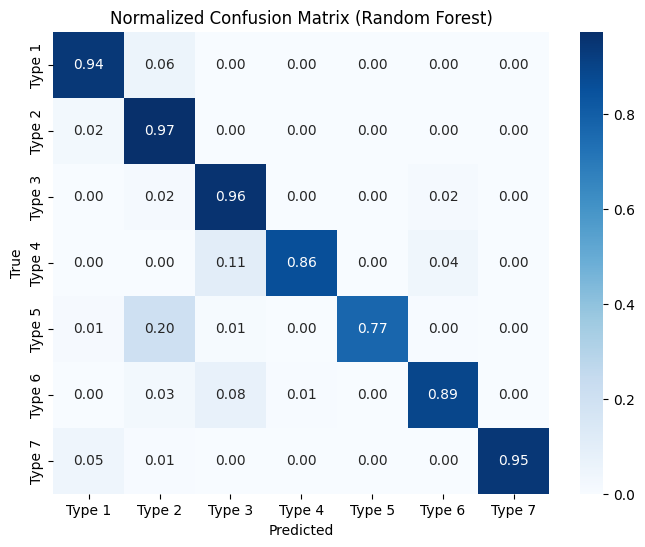

In [20]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=[f"Type {i+1}" for i in range(7)],
            yticklabels=[f"Type {i+1}" for i in range(7)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Random Forest)")
plt.show()


ROC curves (One-vs-Rest for multi-class)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.3s finished


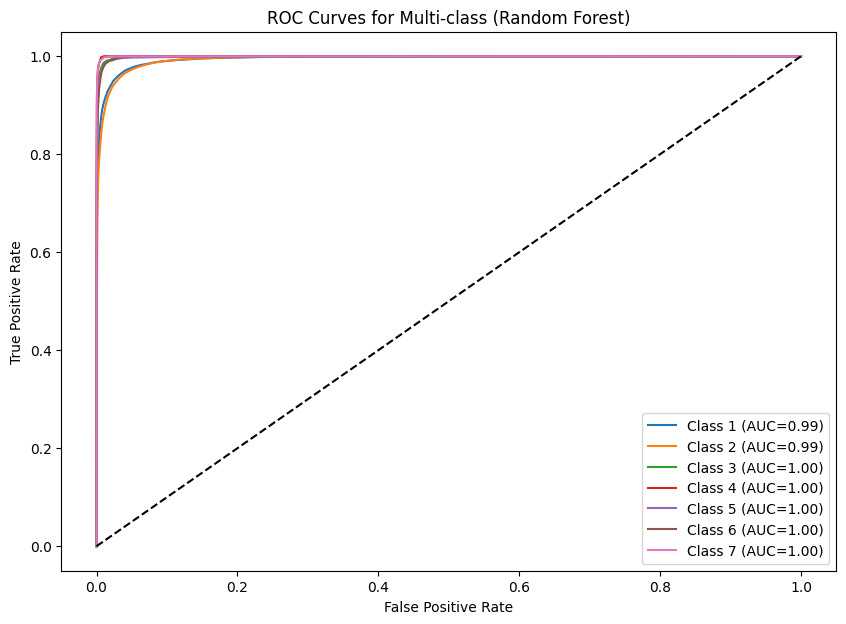

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import numpy as np

y_bin = label_binarize(y_test, classes=list(range(7)))
y_score = rf.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,7))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f"Class {i+1} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-class (Random Forest)")
plt.legend()
plt.show()
